In [1]:
#importing dependencies
import pandas as pd
import numpy as np
import torch
from torch import tensor
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# View the submission format
f = r'C:\Users\Stina\Documents\LEARNING PYTHON\Data I work with\nairobi ambulance prediction\SampleSubmission (1).csv'
df_submit = pd.read_csv(f, parse_dates=['date'])
df_submit.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-07-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-07-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-07-01 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-07-01 09:00:00,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-07-01 12:00:00,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
#Read in the training data
df = pd.read_csv(r'C:\Users\Stina\Documents\LEARNING PYTHON\Data I work with\nairobi ambulance prediction\Train (2).csv')
df

,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382
...,...,...,...,...
6313,6314,2019-06-29 18:52:44,-1.262271,36.726540
6314,6315,2019-06-30 09:57:44,-1.279468,36.790449
6315,6316,2019-06-30 12:02:14,-1.322109,36.825248
6316,6317,2019-06-30 16:59:14,-1.278589,36.816518


In [4]:
#checking for missing values
df.isna().sum()

uid          0
datetime     0
latitude     0
longitude    0
dtype: int64

In [5]:
#Viewing the datatypes of all the columns
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6318 entries, 0 to 6317
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   uid        6318 non-null   int64  
 1   datetime   6318 non-null   object 
 2   latitude   6318 non-null   float64
 3   longitude  6318 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 197.6+ KB


In [6]:
#converting to a datetime object
df['datetime']=pd.to_datetime(df['datetime'])

In [7]:
# Crash locations - turn the training data into a tensor we can work with
crash_locs = tensor(df[['latitude', 'longitude']].values) # To Tensor

In [8]:
#function to help calculate the mean of the distance
def loss_fn(crash_locs, amb_locs):
    """For each crash we find the dist to the closest ambulance, and return the mean of these dists."""
    # Dists to first ambulance
    dists_split = crash_locs-amb_locs[0]
    dists = (dists_split[:,0]**2 + dists_split[:,1]**2)**0.5
    min_dists = dists
    for i in range(1, 6):
        # Update dists so they represent the dist to the closest ambulance
        dists_split = crash_locs-amb_locs[i]
        dists = (dists_split[:,0]**2 + dists_split[:,1]**2)**0.5
        min_dists = torch.min(min_dists, dists)
    return min_dists.mean()

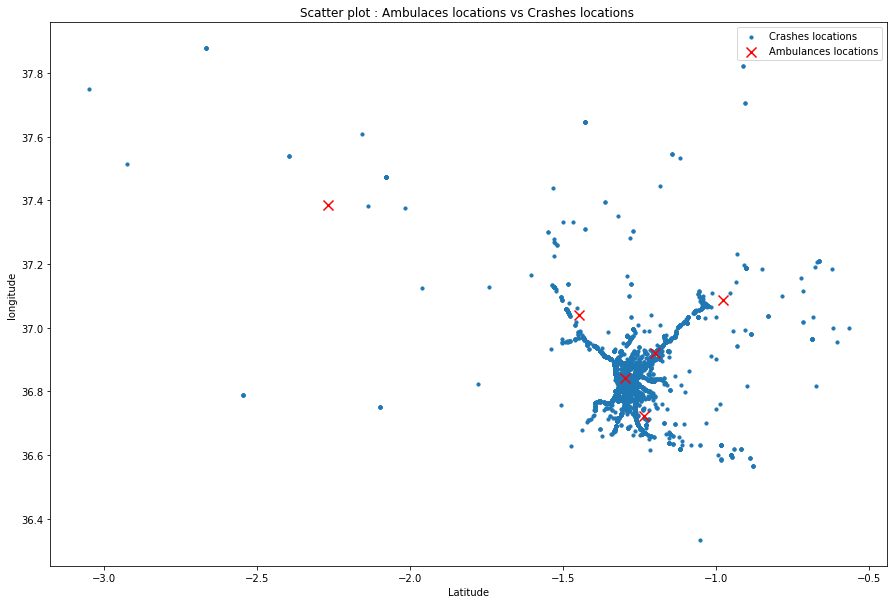

In [14]:
#Using kmeans to create clusters of the 6 locations of the ambulance.

kmeans_global = KMeans(n_clusters=6, random_state=500).fit(df[['latitude','longitude']]) 
#training with the whole dataset without taking time into consideration

fig, axs = plt.subplots(figsize=(15, 10))

plt.scatter(x = df['latitude'],y=df['longitude'], s=10, label='Crashes locations')
plt.scatter(x=kmeans_global.cluster_centers_[:,0], y=kmeans_global.cluster_centers_[:,1],marker="x",
            color='r',label='Ambulances locations',s=100)
plt.title('Scatter plot : Ambulaces locations vs Crashes locations ')
plt.xlabel("Latitude")
plt.ylabel("longitude")
plt.legend()
plt.show()

Working with the stochastic gradient descent: this improved my score on the leaderboard than kmeans

These gradients tell us which way to move the locations to reduce the loss. 
We'll pick a learning rate, and then run through 1000 steps, updating the locations each time:

In [42]:
# Ambulance Locations
amb_locs = torch.randn(6, 2) * 0.04 # 6 pairs of random numbers, made fairly small
amb_locs = amb_locs + tensor((-1.27, 36.85)) # Centered around the middle of town
amb_locs.requires_grad_() # Tell pytorch to calculate gradients
initial_locs = amb_locs.clone() # Save originals for later
amb_locs # View our set of initial locations

tensor([[-1.2211, 36.8053],
        [-1.1952, 36.7529],
        [-1.2688, 36.8415],
        [-1.2755, 36.8211],
        [-1.2763, 36.8731],
        [-1.2889, 36.8221]], requires_grad=True)

In [52]:
# Load crash locs from train into a dataloader

# Set vars
lr=3e-3
n_epochs = 150

# Store loss over time

loc = []
for i in range(0,22,3):
    amb_losses = []
    d = df[(df['datetime'].dt.hour>=i) & (df['datetime'].dt.hour<=i+3)] #getting data in 3 hours interval.
    crash_locs = tensor(d[['latitude', 'longitude']].values) # To Tensor
    dl = torch.utils.data.DataLoader(crash_locs, batch_size=50, shuffle=True)
     # Training loop
    for epoch in range(n_epochs):
        # Run through batches
        for crashes in dl:
            loss = loss_fn(crashes, amb_locs) # Find loss for this batch of crashes
            loss.backward() # Calc grads
            amb_locs.data -= lr * amb_locs.grad.data # Update locs
            amb_losses.append(amb_locs)
            amb_locs.grad = None # Reset gradients for next step
            
    array = []
    for j in range(len(amb_losses)):
        array.append(amb_losses[j].detach().numpy()) #turning the tensors to an array.
    f = np.ravel(np.mean(array,0)) #getting the mean of the values
    df_submit.loc[df_submit['date'].dt.hour == i, ['A0_Latitude','A0_Longitude',
                                     'A1_Latitude','A1_Longitude','A2_Latitude','A2_Longitude',
                                     'A3_Latitude','A3_Longitude','A4_Latitude','A4_Longitude',
                                     'A5_Latitude','A5_Longitude']] = f
    loc.append(f) #Appending the predicted values to a list
    

In [57]:
loc

[array([-1.2668455, 36.742466 , -1.1223601, 36.6496   , -1.2037759,
        36.91768  , -1.2840582, 36.823063 , -1.0721071, 37.026257 ,
        -1.3309332, 36.876175 ], dtype=float32),
 array([-1.2661694, 36.748016 , -1.1116472, 36.63514  , -1.2192426,
        36.890747 , -1.2863641, 36.8226   , -1.0549356, 37.039555 ,
        -1.3314894, 36.88879  ], dtype=float32),
 array([-1.2652532, 36.748936 , -1.0956744, 36.641453 , -1.2196951,
        36.89064  , -1.2852769, 36.82483  , -1.0712823, 37.04688  ,
        -1.3311657, 36.889767 ], dtype=float32),
 array([-1.2651368, 36.748325 , -1.0446632, 36.624573 , -1.219687 ,
        36.89065  , -1.2874453, 36.826702 , -1.0708579, 37.041138 ,
        -1.3447174, 36.90456  ], dtype=float32),
 array([-1.2763191 , 36.742313  , -0.96535134, 36.60768   , -1.2189912 ,
        36.891052  , -1.2849674 , 36.826042  , -1.0559261 , 37.054684  ,
        -1.3325336 , 36.884495  ], dtype=float32),
 array([-1.2734367, 36.749542 , -0.9500049, 36.6011   , -1.2036

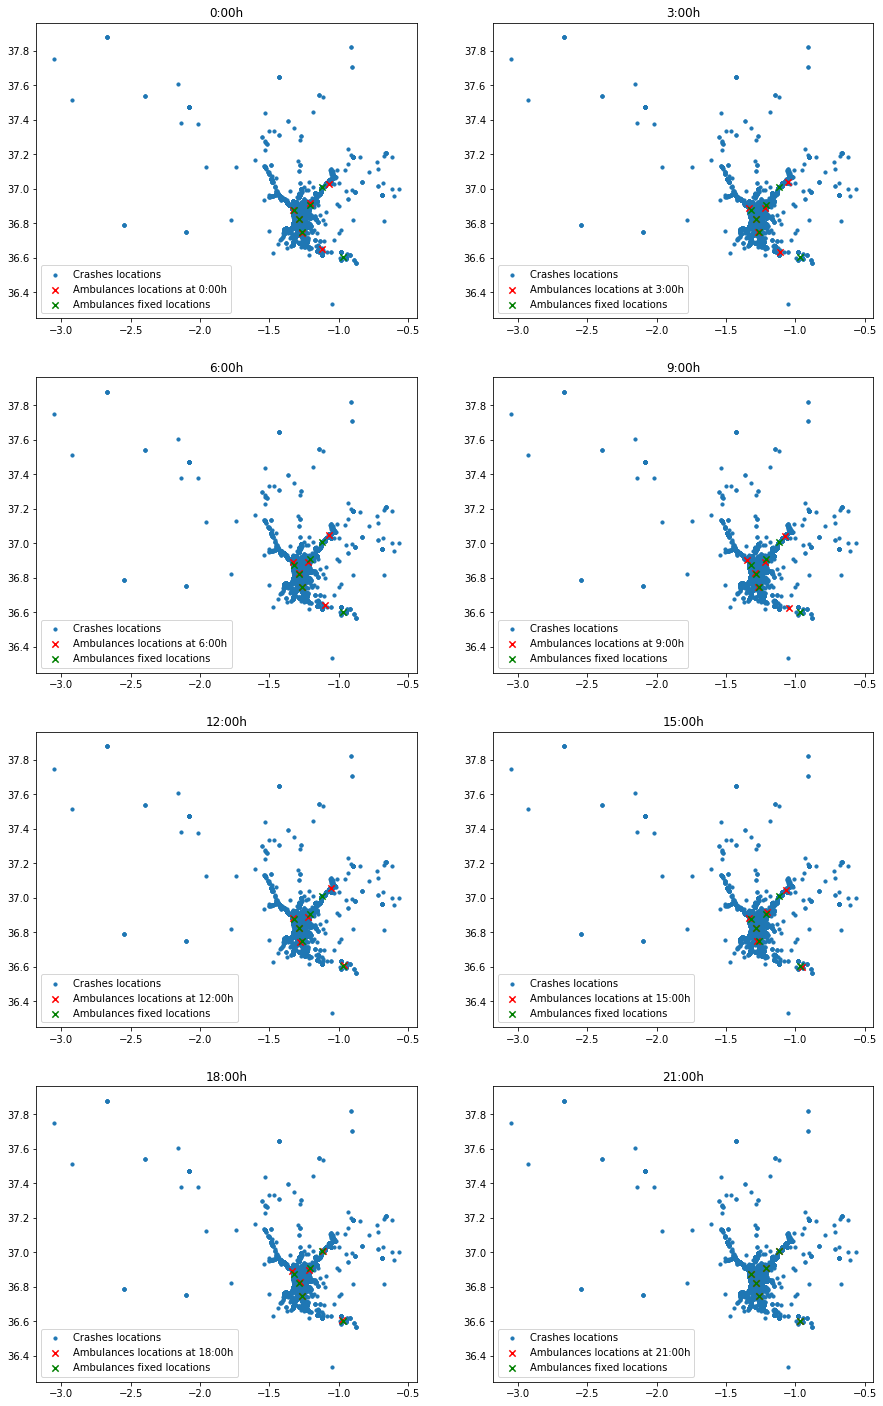

In [65]:
#Visualizing
fig, axs = plt.subplots(4, 2,figsize=(15, 25))


x = [loc[0][x] for x in range(0,len(loc[0]),2)] #to find the latitudes
y = [loc[0][x+1] for x in range(0,len(loc[0]),2)] #to find the longitudes
new_amb_locs = amb_locs.detach().numpy().flatten() #turned to a flattened array
init_x = [new_amb_locs[x] for x in range(0,len(new_amb_locs),2)]  
init_y = [new_amb_locs[x+1] for x in range(0,len(new_amb_locs),2)]  
axs[0, 0].scatter(x = df['latitude'],y=df['longitude'],s=10, label='Crashes locations')
axs[0, 0].set_title('0:00h')
axs[0, 0].scatter(x= x, y= y,marker="x", color='r',label='Ambulances locations at 0:00h',s=40)
axs[0, 0].scatter(x=init_x,y=init_y,marker="x", color='g',label='Ambulances fixed locations',s=40)
axs[0, 0].legend()   

x = [loc[1][x] for x in range(0,len(loc[1]),2)] #to find the latitudes
y = [loc[1][x+1] for x in range(0,len(loc[1]),2)] #to find the longitudes
new_amb_locs = amb_locs.detach().numpy().flatten() #turned to a flattened array
init_x = [new_amb_locs[x] for x in range(0,len(new_amb_locs),2)]  
init_y = [new_amb_locs[x+1] for x in range(0,len(new_amb_locs),2)]  
axs[0, 1].scatter(x = df['latitude'],y=df['longitude'],s=10, label='Crashes locations')
axs[0, 1].set_title('3:00h')
axs[0, 1].scatter(x= x, y= y,marker="x", color='r',label='Ambulances locations at 3:00h',s=40)
axs[0, 1].scatter(x=init_x,y=init_y,marker="x", color='g',label='Ambulances fixed locations',s=40)
axs[0, 1].legend() 

x = [loc[2][x] for x in range(0,len(loc[2]),2)] #to find the latitudes
y = [loc[2][x+1] for x in range(0,len(loc[2]),2)] #to find the longitudes
new_amb_locs = amb_locs.detach().numpy().flatten() #turned to a flattened array
init_x = [new_amb_locs[x] for x in range(0,len(new_amb_locs),2)]  
init_y = [new_amb_locs[x+1] for x in range(0,len(new_amb_locs),2)]  
axs[1, 0].scatter(x = df['latitude'],y=df['longitude'],s=10, label='Crashes locations')
axs[1, 0].set_title('6:00h')
axs[1, 0].scatter(x= x, y= y,marker="x", color='r',label='Ambulances locations at 6:00h',s=40)
axs[1, 0].scatter(x=init_x,y=init_y,marker="x", color='g',label='Ambulances fixed locations',s=40)
axs[1, 0].legend()

x = [loc[3][x] for x in range(0,len(loc[3]),2)] #to find the latitudes
y = [loc[3][x+1] for x in range(0,len(loc[3]),2)] #to find the longitudes
new_amb_locs = amb_locs.detach().numpy().flatten() #turned to a flattened array
init_x = [new_amb_locs[x] for x in range(0,len(new_amb_locs),2)]  
init_y = [new_amb_locs[x+1] for x in range(0,len(new_amb_locs),2)]  
axs[1, 1].scatter(x = df['latitude'],y=df['longitude'],s=10, label='Crashes locations')
axs[1, 1].set_title('9:00h')
axs[1, 1].scatter(x= x, y= y,marker="x", color='r',label='Ambulances locations at 9:00h',s=40)
axs[1, 1].scatter(x=init_x,y=init_y,marker="x", color='g',label='Ambulances fixed locations',s=40)
axs[1, 1].legend()

x = [loc[4][x] for x in range(0,len(loc[4]),2)] #to find the latitudes
y = [loc[4][x+1] for x in range(0,len(loc[4]),2)] #to find the longitudes
new_amb_locs = amb_locs.detach().numpy().flatten() #turned to a flattened array
init_x = [new_amb_locs[x] for x in range(0,len(new_amb_locs),2)]  
init_y = [new_amb_locs[x+1] for x in range(0,len(new_amb_locs),2)]  
axs[2, 0].scatter(x = df['latitude'],y=df['longitude'],s=10, label='Crashes locations')
axs[2, 0].set_title('12:00h')
axs[2, 0].scatter(x= x, y= y,marker="x", color='r',label='Ambulances locations at 12:00h',s=40)
axs[2, 0].scatter(x=init_x,y=init_y,marker="x", color='g',label='Ambulances fixed locations',s=40)
axs[2, 0].legend()   

x = [loc[5][x] for x in range(0,len(loc[5]),2)] #to find the latitudes
y = [loc[5][x+1] for x in range(0,len(loc[5]),2)] #to find the longitudes
new_amb_locs = amb_locs.detach().numpy().flatten() #turned to a flattened array
init_x = [new_amb_locs[x] for x in range(0,len(new_amb_locs),2)]  
init_y = [new_amb_locs[x+1] for x in range(0,len(new_amb_locs),2)]  
axs[2, 1].scatter(x = df['latitude'],y=df['longitude'],s=10, label='Crashes locations')
axs[2, 1].set_title('15:00h')
axs[2, 1].scatter(x= x, y= y,marker="x", color='r',label='Ambulances locations at 15:00h',s=40)
axs[2, 1].scatter(x=init_x,y=init_y,marker="x", color='g',label='Ambulances fixed locations',s=40)
axs[2, 1].legend() 

x = [loc[6][x] for x in range(0,len(loc[6]),2)] #to find the latitudes
y = [loc[6][x+1] for x in range(0,len(loc[6]),2)] #to find the longitudes
new_amb_locs = amb_locs.detach().numpy().flatten() #turned to a flattened array
init_x = [new_amb_locs[x] for x in range(0,len(new_amb_locs),2)]  
init_y = [new_amb_locs[x+1] for x in range(0,len(new_amb_locs),2)]  
axs[3, 0].scatter(x = df['latitude'],y=df['longitude'],s=10, label='Crashes locations')
axs[3, 0].set_title('18:00h')
axs[3, 0].scatter(x= x, y= y,marker="x", color='r',label='Ambulances locations at 18:00h',s=40)
axs[3, 0].scatter(x=init_x,y=init_y,marker="x", color='g',label='Ambulances fixed locations',s=40)
axs[3, 0].legend()   

x = [loc[7][x] for x in range(0,len(loc[7]),2)] #to find the latitudes
y = [loc[7][x+1] for x in range(0,len(loc[7]),2)] #to find the longitudes
new_amb_locs = amb_locs.detach().numpy().flatten() #turned to a flattened array
init_x = [new_amb_locs[x] for x in range(0,len(new_amb_locs),2)]  
init_y = [new_amb_locs[x+1] for x in range(0,len(new_amb_locs),2)]  
axs[3, 1].scatter(x = df['latitude'],y=df['longitude'],s=10, label='Crashes locations')
axs[3, 1].set_title('21:00h')
axs[3, 1].scatter(x= x, y= y,marker="x", color='r',label='Ambulances locations at 21:00h',s=40)
axs[3, 1].scatter(x=init_x,y=init_y,marker="x", color='g',label='Ambulances fixed locations',s=40)
axs[3, 1].legend()   


In [66]:
df_submit

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-07-01 00:00:00,-1.266845,36.742466,-1.122360,36.649601,-1.203776,36.917679,-1.284058,36.823063,-1.072107,37.026257,-1.330933,36.876175
1,2019-07-01 03:00:00,-1.266169,36.748016,-1.111647,36.635139,-1.219243,36.890747,-1.286364,36.822601,-1.054936,37.039555,-1.331489,36.888790
2,2019-07-01 06:00:00,-1.265253,36.748936,-1.095674,36.641453,-1.219695,36.890640,-1.285277,36.824829,-1.071282,37.046879,-1.331166,36.889767
3,2019-07-01 09:00:00,-1.265137,36.748325,-1.044663,36.624573,-1.219687,36.890652,-1.287445,36.826702,-1.070858,37.041138,-1.344717,36.904560
4,2019-07-01 12:00:00,-1.276319,36.742313,-0.965351,36.607681,-1.218991,36.891052,-1.284967,36.826042,-1.055926,37.054684,-1.332534,36.884495
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2019-12-31 09:00:00,-1.265137,36.748325,-1.044663,36.624573,-1.219687,36.890652,-1.287445,36.826702,-1.070858,37.041138,-1.344717,36.904560
1468,2019-12-31 12:00:00,-1.276319,36.742313,-0.965351,36.607681,-1.218991,36.891052,-1.284967,36.826042,-1.055926,37.054684,-1.332534,36.884495
1469,2019-12-31 15:00:00,-1.273437,36.749542,-0.950005,36.601101,-1.203666,36.916233,-1.282666,36.827747,-1.066456,37.046871,-1.334273,36.884964
1470,2019-12-31 18:00:00,-1.264206,36.748104,-0.979021,36.607830,-1.215869,36.898434,-1.281693,36.826607,-1.116470,37.008289,-1.333322,36.890125


In [67]:
df_submit.to_csv('nairobi solution.csv')

In [68]:
#This approach gave me a rank of 30 and a minimum distance of 43.9 on zindi leaderboard.